In [18]:
# Imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [32]:
# ========================================
# MODULAR GAN SYSTEM
# ========================================

class EEGGANTrainer:
    """
    Reusable GAN trainer for EEG data
    
    Usage:
        trainer = EEGGANTrainer(data, name='my_experiment')
        trainer.train(epochs=100)
        synthetic = trainer.generate(n_samples=100)
    """
    
    def __init__(self, data, name='experiment', device='cpu'):
        """
        Initialize GAN trainer
        
        Parameters:
        -----------
        data : numpy array
            EEG data with shape (n_samples, n_channels, n_timepoints)
        name : str
            Name for this experiment (used for saving models/results)
        device : str
            'cpu' or 'cuda'
        """
        self.data = data
        self.name = name
        self.device = device
        
        # Extract dimensions
        self.n_samples = data.shape[0]
        self.n_channels = data.shape[1]
        self.n_timepoints = data.shape[2]
        
        print(f"Initialized EEGGANTrainer: {name}")
        print(f"  Data shape: {data.shape}")
        print(f"  Device: {device}")
        
        # Create models
        self._create_models()
        
        # Create dataset
        self._create_dataset()
        
        # Training history
        self.history = {'G_losses': [], 'D_losses': [], 'std_errors': []}
        self.best_std_error = float('inf')
        self.best_epoch = 0
    
    def _create_models(self):
        """Create deeper Generator and Discriminator"""
        data_size = self.n_channels * self.n_timepoints
        
        # DEEPER Generator (4 layers instead of 2)
        self.G = nn.Sequential(
            nn.Linear(data_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, data_size)
        ).to(self.device)
        
        # DEEPER Discriminator (4 layers instead of 2)
        self.D = nn.Sequential(
            nn.Linear(data_size, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 1),
            nn.Sigmoid()
        ).to(self.device)
        
        print(f"✓ Enhanced models created")
        print(f"  Generator: {sum(p.numel() for p in self.G.parameters()):,} params")
        print(f"  Discriminator: {sum(p.numel() for p in self.D.parameters()):,} params")
    
    def _create_dataset(self):
        """Create PyTorch dataset and dataloader"""
        class EEGDataset(Dataset):
            def __init__(self, data):
                self.data = torch.FloatTensor(data)
            def __len__(self):
                return len(self.data)
            def __getitem__(self, idx):
                return self.data[idx]
        
        dataset = EEGDataset(self.data)
        self.dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        print(f"✓ Dataset ready: {len(dataset)} samples, {len(self.dataloader)} batches")
    
    def train(self, epochs=300, lr=0.00005, save_best=True):
        """Enhanced training with spectral loss"""
        criterion = nn.BCELoss()
        G_opt = optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        
        print(f"\nTraining IMPROVED {self.name} for {epochs} epochs...")
        print("="*60)
        
        for epoch in range(epochs):
            G_losses, D_losses = [], []
            
            for real_eeg in self.dataloader:
                real_eeg = real_eeg.to(self.device)
                batch_size = real_eeg.shape[0]
                
                # Train Discriminator
                D_opt.zero_grad()
                real_pred = self.D(real_eeg.reshape(batch_size, -1))
                real_labels = torch.ones(batch_size, 1, device=self.device) * 0.9
                loss_real = criterion(real_pred, real_labels)
                
                noise = torch.randn_like(real_eeg, device=self.device)
                fake_eeg = self.G(noise.reshape(batch_size, -1))
                fake_pred = self.D(fake_eeg.detach())
                fake_labels = torch.zeros(batch_size, 1, device=self.device) * 0.1
                loss_fake = criterion(fake_pred, fake_labels)
                
                D_loss = (loss_real + loss_fake) / 2
                D_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.D.parameters(), 1.0)
                D_opt.step()
                
                # Train Generator with SPECTRAL LOSS
                G_opt.zero_grad()
                noise = torch.randn_like(real_eeg, device=self.device)
                fake_eeg = self.G(noise.reshape(batch_size, -1))
                fake_pred = self.D(fake_eeg)
                
                fake_eeg_reshaped = fake_eeg.reshape(batch_size, self.n_channels, self.n_timepoints)
                
                # Adversarial loss
                G_loss_adv = criterion(fake_pred, torch.ones(batch_size, 1, device=self.device))
                
                # Statistical loss (std matching)
                std_penalty = 0.1 * (fake_eeg_reshaped.std() - real_eeg.std()) ** 2
                
                # SPECTRAL LOSS (frequency matching)
                real_fft = torch.fft.rfft(real_eeg, dim=-1)
                fake_fft = torch.fft.rfft(fake_eeg_reshaped, dim=-1)
                spectral_loss = torch.mean((torch.abs(real_fft) - torch.abs(fake_fft)) ** 2)
                
                # Combined loss
                G_loss = G_loss_adv + 0.1 * std_penalty + 0.5 * spectral_loss
                
                G_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.G.parameters(), 1.0)
                G_opt.step()
                
                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())
            
            # Track metrics
            self.history['G_losses'].append(np.mean(G_losses))
            self.history['D_losses'].append(np.mean(D_losses))
            
            # Evaluate every 20 epochs
            if (epoch + 1) % 20 == 0:
                std_error = self._evaluate()
                self.history['std_errors'].append(std_error)
                
                if save_best and std_error < self.best_std_error:
                    self.best_std_error = std_error
                    self.best_epoch = epoch + 1
                    self.save_model()
                
                print(f"Epoch {epoch+1:3d}/{epochs} | "
                      f"D: {self.history['D_losses'][-1]:.4f} | "
                      f"G: {self.history['G_losses'][-1]:.4f} | "
                      f"Std_err: {std_error:.4f} | "
                      f"Best: {self.best_std_error:.4f} @ {self.best_epoch}")
        
        print("="*60)
        print(f"✓ Enhanced training complete!")
        if save_best:
            self.load_best_model()
    
    def _evaluate(self):
        """Evaluate current model quality"""
        with torch.no_grad():
            noise = torch.randn(100, self.n_channels, self.n_timepoints, device=self.device)
            fake = self.G(noise.reshape(100, -1))
            fake_reshaped = fake.reshape(100, self.n_channels, self.n_timepoints)
            fake_std = fake_reshaped.cpu().numpy().std()
            real_std = self.data.std()
            return abs(fake_std - real_std)
    
    def generate(self, n_samples=100):
        """Generate synthetic EEG samples"""
        self.G.eval()
        samples = []
        
        with torch.no_grad():
            for i in range(n_samples):
                noise = torch.randn(1, self.n_channels, self.n_timepoints, device=self.device)
                fake = self.G(noise.reshape(1, -1))
                fake_reshaped = fake.reshape(self.n_channels, self.n_timepoints)
                samples.append(fake_reshaped.cpu().numpy())
        
        return np.array(samples)
    
    def save_model(self):
        """Save model to file"""
        os.makedirs('../../models', exist_ok=True)
        path = f'../../models/gan_{self.name}.pt'
        torch.save({'G': self.G.state_dict(), 'D': self.D.state_dict()}, path)
    
    def load_best_model(self):
        """Load best saved model"""
        path = f'../../models/gan_{self.name}.pt'
        checkpoint = torch.load(path)
        self.G.load_state_dict(checkpoint['G'])
        self.D.load_state_dict(checkpoint['D'])
        print(f"✓ Loaded best model from {path}")
    
    def evaluate(self, synthetic_data):
        """
        Comprehensive evaluation of synthetic data quality
        
        Returns:
        --------
        dict : Evaluation metrics including MMD, statistical errors, quality score
        """
        # Statistical comparison
        mean_error = abs(self.data.mean() - synthetic_data.mean())
        std_error = abs(self.data.std() - synthetic_data.std())
        
        # MMD computation
        n_eval = min(1000, len(self.data), len(synthetic_data))
        mmd = self._compute_mmd(self.data[:n_eval], synthetic_data[:n_eval])
        
        # Quality score (0-100)
        stat_score = max(0, 100 - (mean_error * 1000 + std_error * 100))
        mmd_score = max(0, 100 - (mmd * 1000))
        overall = (stat_score + mmd_score) / 2
        
        results = {
            'mean_error': mean_error,
            'std_error': std_error,
            'mmd_rbf': mmd,
            'stat_score': stat_score,
            'mmd_score': mmd_score,
            'overall_score': overall,
            'quality': self._get_quality_label(overall)
        }
        
        return results
    
    def _compute_mmd(self, real_data, fake_data):
        """Compute MMD with RBF kernel"""
        real_flat = torch.FloatTensor(real_data.reshape(real_data.shape[0], -1))
        fake_flat = torch.FloatTensor(fake_data.reshape(fake_data.shape[0], -1))
        
        def gaussian_kernel(x, y):
            x_norm = (x ** 2).sum(1).view(-1, 1)
            y_norm = (y ** 2).sum(1).view(1, -1)
            dist = x_norm + y_norm - 2.0 * torch.mm(x, y.t())
            gamma = 1.0 / (2 * torch.median(dist[dist > 0]))
            return torch.exp(-gamma * dist)
        
        K_rr = gaussian_kernel(real_flat, real_flat)
        K_ff = gaussian_kernel(fake_flat, fake_flat)
        K_rf = gaussian_kernel(real_flat, fake_flat)
        
        n_r, n_f = len(real_flat), len(fake_flat)
        mmd_sq = (K_rr.sum() / (n_r * (n_r - 1)) +
                  K_ff.sum() / (n_f * (n_f - 1)) -
                  2 * K_rf.sum() / (n_r * n_f))
        
        return torch.sqrt(torch.clamp(mmd_sq, min=0.0)).item()
    
    def _get_quality_label(self, score):
        """Convert score to quality label"""
        if score >= 80: return "Excellent ⭐⭐⭐⭐⭐"
        if score >= 60: return "Good ⭐⭐⭐⭐"
        if score >= 40: return "Fair ⭐⭐⭐"
        return "Needs Improvement ⭐⭐"
    
    def plot_comparison(self, synthetic_data, save_path=None):
        """Plot comparison between real and synthetic data"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        
        axes[0, 0].plot(self.data[0].T, alpha=0.5, linewidth=0.5)
        axes[0, 0].set_title(f'Real {self.name} - All Channels', fontweight='bold')
        axes[0, 0].set_ylim(-4, 4)
        
        axes[0, 1].plot(synthetic_data[0].T, alpha=0.5, linewidth=0.5)
        axes[0, 1].set_title(f'Generated {self.name} - All Channels', fontweight='bold')
        axes[0, 1].set_ylim(-4, 4)
        
        axes[1, 0].plot(self.data[0, 0], label='Real', alpha=0.7, linewidth=2)
        axes[1, 0].plot(synthetic_data[0, 0], label='Generated', alpha=0.7, linewidth=2)
        axes[1, 0].set_title('Single Channel', fontweight='bold')
        axes[1, 0].legend()
        
        axes[1, 1].hist(self.data.flatten(), bins=50, alpha=0.5, label='Real', density=True)
        axes[1, 1].hist(synthetic_data.flatten(), bins=50, alpha=0.5, label='Generated', density=True)
        axes[1, 1].set_title('Amplitude Distribution', fontweight='bold')
        axes[1, 1].legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        plt.show()
    
    def save_results(self, synthetic_data, evaluation):
        """Save synthetic data and evaluation results"""
        os.makedirs('../../synthetic_data', exist_ok=True)
        
        # Save synthetic data
        data_path = f'../../synthetic_data/synthetic_{self.name}.npy'
        np.save(data_path, synthetic_data)
        
        # Save evaluation
        eval_path = f'../../synthetic_data/evaluation_{self.name}.npy'
        np.save(eval_path, evaluation)
        
        print(f"✓ Saved results for {self.name}")

print("✓ EEGGANTrainer class loaded")

✓ EEGGANTrainer class loaded


Opening raw data file ..\..\gan_data\eyes_closed_segments.fif...
Isotrak not found
    Range : 0 ... 2499 =      0.000 ...     4.998 secs
Ready.
Isotrak not found
    Range : 0 ... 2499 =      0.000 ...     4.998 secs
Ready.
Reading 0 ... 2499  =      0.000 ...     4.998 secs...
Reading 0 ... 2499  =      0.000 ...     4.998 secs...
✓ Loaded eyes closed: (5, 129, 500)
Initialized EEGGANTrainer: eyes_closed
  Data shape: (5, 129, 500)
  Device: cuda
✓ Loaded eyes closed: (5, 129, 500)
Initialized EEGGANTrainer: eyes_closed
  Data shape: (5, 129, 500)
  Device: cuda
✓ Enhanced models created
  Generator: 99,929,076 params
  Discriminator: 33,188,865 params
✓ Dataset ready: 5 samples, 1 batches

Training IMPROVED eyes_closed for 300 epochs...
✓ Enhanced models created
  Generator: 99,929,076 params
  Discriminator: 33,188,865 params
✓ Dataset ready: 5 samples, 1 batches

Training IMPROVED eyes_closed for 300 epochs...
Epoch  20/300 | D: 0.1696 | G: 195.3855 | Std_err: 0.5582 | Best: 0.558

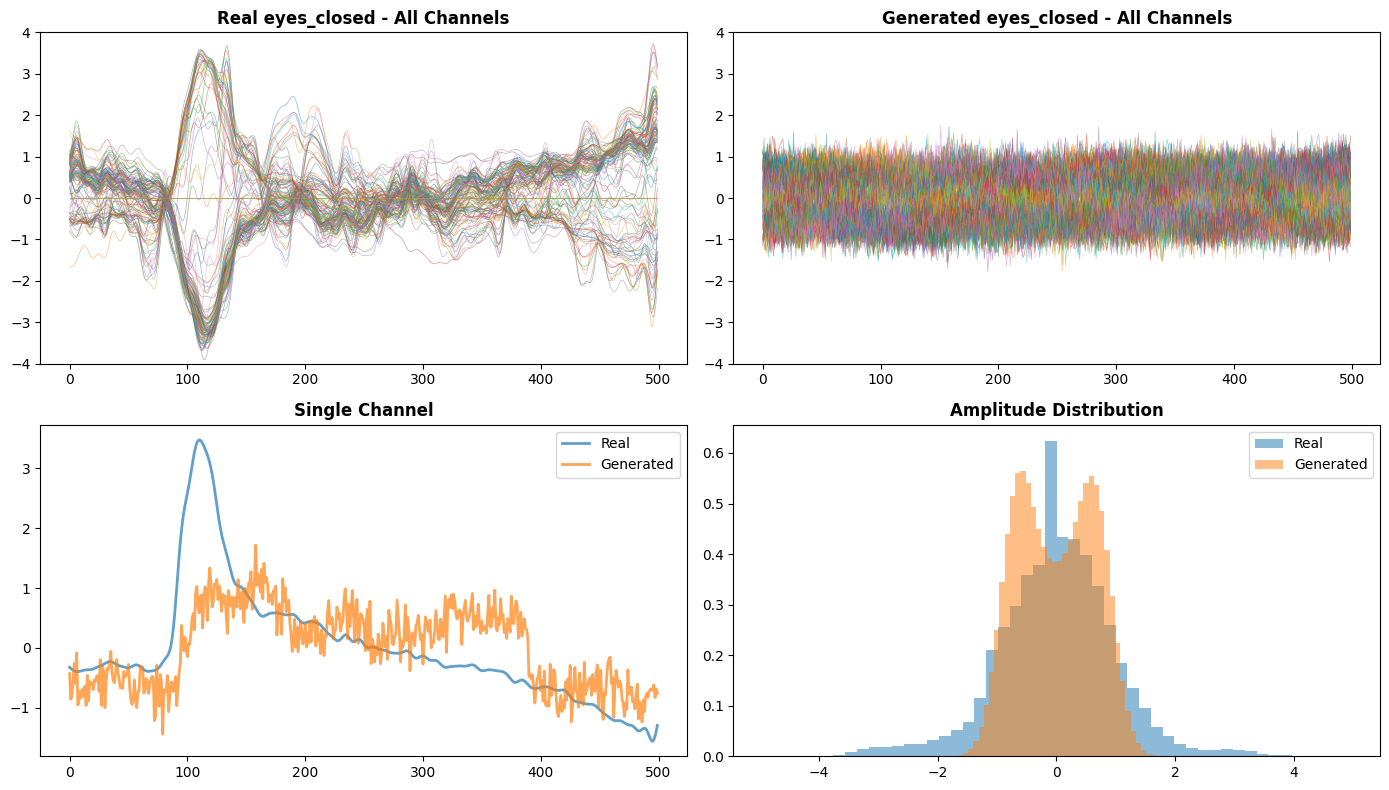

✓ Saved results for eyes_closed


In [33]:
# Load your preprocessed data
processed_dir = os.path.join('..', '..', 'gan_data')
metadata_closed = np.load(os.path.join(processed_dir, 'eyes_closed_metadata.npy'), allow_pickle=True).item()
raw_closed = mne.io.read_raw_fif(os.path.join(processed_dir, 'eyes_closed_segments.fif'), preload=True)

# Reshape to segments
n_channels = metadata_closed['n_channels']
n_timepoints = metadata_closed['n_timepoints']
n_segments = metadata_closed['n_segments']
data_closed = raw_closed.get_data()
segments_closed = data_closed.reshape(n_channels, n_segments, n_timepoints).transpose(1, 0, 2)

print(f"✓ Loaded eyes closed: {segments_closed.shape}")

# TRAIN IN 3 LINES!
trainer_closed = EEGGANTrainer(segments_closed, name='eyes_closed', device=device)
trainer_closed.train()
synthetic_closed = trainer_closed.generate(n_samples=100)

# Evaluate
eval_closed = trainer_closed.evaluate(synthetic_closed)
print("\n" + "="*60)
print("EVALUATION RESULTS: EYES CLOSED")
print("="*60)
for key, value in eval_closed.items():
    print(f"  {key}: {value}")
print("="*60)

# Visualize
trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')

# Save
trainer_closed.save_results(synthetic_closed, eval_closed)

Opening raw data file ..\..\gan_data\eyes_open_segments.fif...
Isotrak not found
    Range : 0 ... 2499 =      0.000 ...     4.998 secs
Ready.
Isotrak not found
    Range : 0 ... 2499 =      0.000 ...     4.998 secs
Ready.
Reading 0 ... 2499  =      0.000 ...     4.998 secs...
Reading 0 ... 2499  =      0.000 ...     4.998 secs...
✓ Loaded eyes open: (5, 129, 500)
Initialized EEGGANTrainer: eyes_open
  Data shape: (5, 129, 500)
  Device: cuda
✓ Loaded eyes open: (5, 129, 500)
Initialized EEGGANTrainer: eyes_open
  Data shape: (5, 129, 500)
  Device: cuda
✓ Enhanced models created
  Generator: 99,929,076 params
  Discriminator: 33,188,865 params
✓ Dataset ready: 5 samples, 1 batches

Training IMPROVED eyes_open for 300 epochs...
✓ Enhanced models created
  Generator: 99,929,076 params
  Discriminator: 33,188,865 params
✓ Dataset ready: 5 samples, 1 batches

Training IMPROVED eyes_open for 300 epochs...
Epoch  20/300 | D: 0.1743 | G: 192.9175 | Std_err: 0.5575 | Best: 0.5575 @ 20
Epoch  

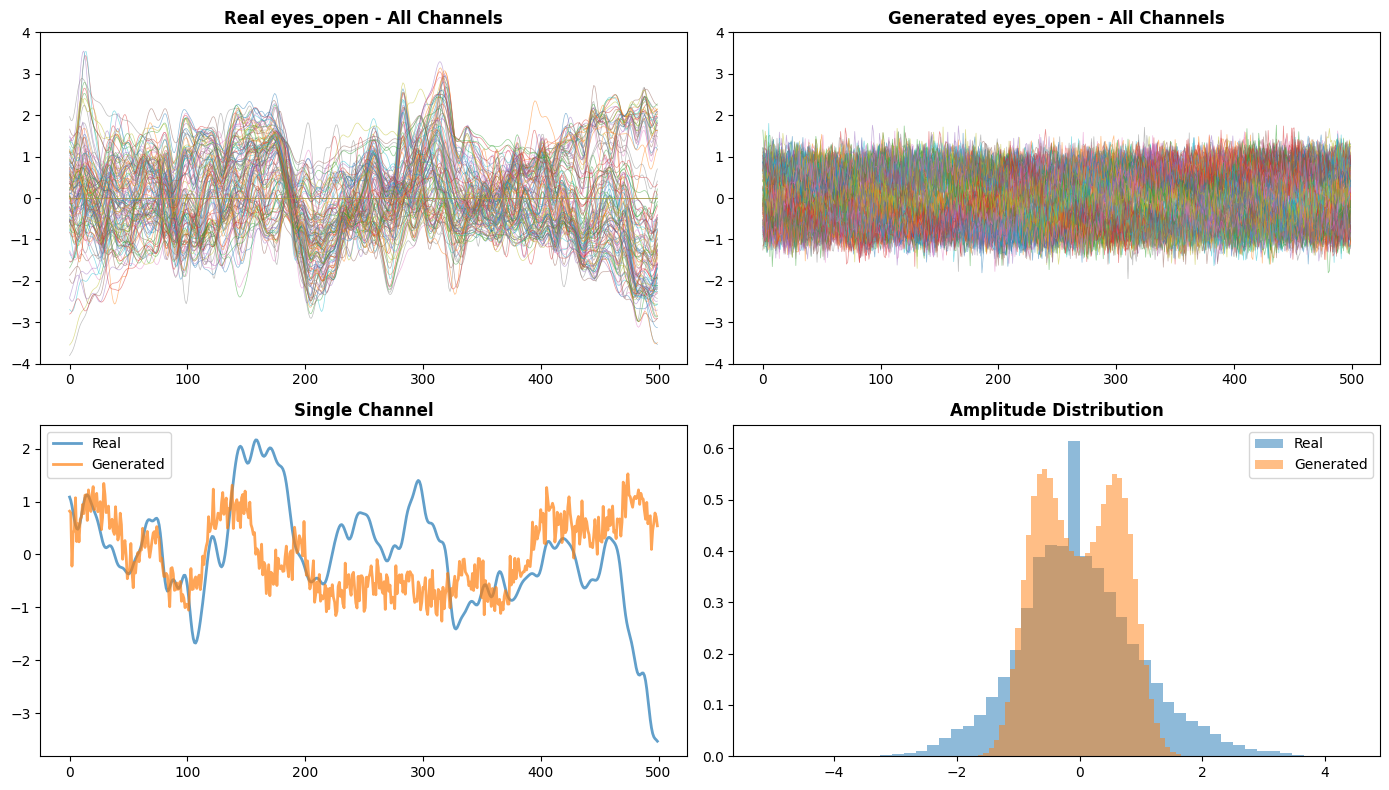

✓ Saved results for eyes_open


In [34]:
# Load eyes open data
metadata_open = np.load(os.path.join(processed_dir, 'eyes_open_metadata.npy'), allow_pickle=True).item()
raw_open = mne.io.read_raw_fif(os.path.join(processed_dir, 'eyes_open_segments.fif'), preload=True)

n_segments_open = metadata_open['n_segments']
data_open = raw_open.get_data()
segments_open = data_open.reshape(n_channels, n_segments_open, n_timepoints).transpose(1, 0, 2)

print(f"✓ Loaded eyes open: {segments_open.shape}")

# TRAIN IN 3 LINES!
trainer_open = EEGGANTrainer(segments_open, name='eyes_open', device=device)
trainer_open.train()
synthetic_open = trainer_open.generate(n_samples=100)

# Evaluate
eval_open = trainer_open.evaluate(synthetic_open)
print("\n" + "="*60)
print("EVALUATION RESULTS: EYES OPEN")
print("="*60)
for key, value in eval_open.items():
    print(f"  {key}: {value}")
print("="*60)

# Visualize
trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')

# Save
trainer_open.save_results(synthetic_open, eval_open)

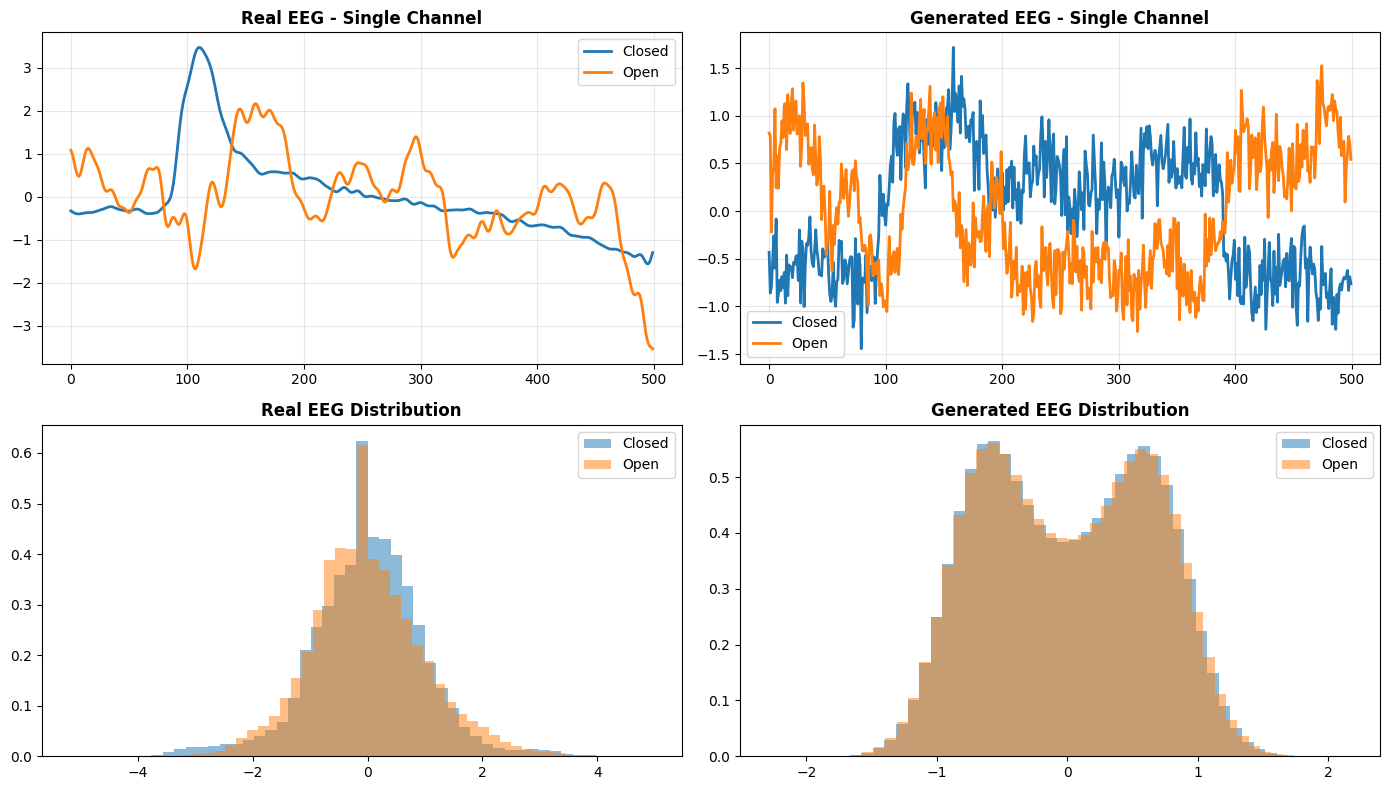


FINAL SUMMARY

Eyes Closed:
  Quality Score: 33.1/100
  Rating: Needs Improvement ⭐⭐

Eyes Open:
  Quality Score: 33.0/100
  Rating: Needs Improvement ⭐⭐

Average: 33.1/100


In [35]:
# Side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(segments_closed[0, 0], label='Closed', linewidth=2)
axes[0, 0].plot(segments_open[0, 0], label='Open', linewidth=2)
axes[0, 0].set_title('Real EEG - Single Channel', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(synthetic_closed[0, 0], label='Closed', linewidth=2)
axes[0, 1].plot(synthetic_open[0, 0], label='Open', linewidth=2)
axes[0, 1].set_title('Generated EEG - Single Channel', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(segments_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 0].hist(segments_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 0].set_title('Real EEG Distribution', fontweight='bold')
axes[1, 0].legend()

axes[1, 1].hist(synthetic_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 1].hist(synthetic_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 1].set_title('Generated EEG Distribution', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../../figures/closed_vs_open_final.png', dpi=150)
plt.show()

# Summary report
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nEyes Closed:")
print(f"  Quality Score: {eval_closed['overall_score']:.1f}/100")
print(f"  Rating: {eval_closed['quality']}")
print(f"\nEyes Open:")
print(f"  Quality Score: {eval_open['overall_score']:.1f}/100")
print(f"  Rating: {eval_open['quality']}")
print(f"\nAverage: {(eval_closed['overall_score'] + eval_open['overall_score'])/2:.1f}/100")
print("="*70)